# Preprocessing

In [2]:
%load_ext autoreload
%autoreload 2 
from IPython.display import Image, display

## 1 Download data

> **Warning 1: Downsampled Data**
>
> In this notebook we illustrate how to download and review results
> using unrealistic downsampled data. Therefore, this notebook should
> not be taken to represent the results of applying the model to real
> data.

We download an example data set to be used for illustration of the
preprocessing steps.

> **Warning 2: Mutable objects**
>
> Ideally we would work with immutable data structures to avoid losing
> information about how a given data object has been transformed.
> However, the usual object-oriented approach relies on repeated
> mutation of the same object. The only defense against confusion we
> have here is to review the updated properties of the underlying object
> after applying effectful methods or functions that have the ability to
> mutate an object’s state in any way. This is why we use the
> `pyrovelocity.utils.anndata_string` function after each step that may
> mutate the data object. Of course, without hashing each subcomponent
> we will still not be able to verify that pre-existing components of
> the object were not modified but at least we can verify the
> relationship between added and removed components this way.

In [3]:
from pyrovelocity.tasks.data import download_dataset
from pyrovelocity.tasks.data import load_anndata_from_path
from pyrovelocity.utils import anndata_string, print_string_diff

dataset_path = download_dataset(data_set_name="pancreas")
adata = load_anndata_from_path(dataset_path)
initial_data_state_representation = anndata_string(adata)
print(initial_data_state_representation)

[20:56:24] INFO pyrovelocity.tasks.data 
 
 Verifying existence of path for downloaded data: data/external

INFO pyrovelocity.tasks.data 
 
 Verifying pancreas data: 
 data will be stored in data/external/pancreas.h5ad

INFO pyrovelocity.tasks.data data/external/pancreas.h5ad exists

INFO pyrovelocity.tasks.data Reading input file: data/external/pancreas.h5ad


AnnData object with n_obs × n_vars = 3696 × 27998
    obs:
        clusters_coarse,
        clusters,
        S_score,
        G2M_score,
    var:
        highly_variable_genes,
    uns:
        clusters_coarse_colors,
        clusters_colors,
        day_colors,
        neighbors,
        pca,
    obsm:
        X_pca,
        X_umap,
    layers:
        spliced,
        unspliced,
    obsp:
        distances,
        connectivities,

## 2 Preprocessing steps

### 2.1 Subset data

We will eventually scale up the analysis to the full data set, but it is
helpful to run experiments on downsampled data to speed up iteration
prior to running on the full data set. Here we downsample the data to
300 observations and 200 variables. Some steps may benefit from even
further downsampling but this is often a good starting point.

In [4]:
import os
import numpy as np
from pyrovelocity.utils import str_to_bool

PYROVELOCITY_DATA_SUBSET = str_to_bool(
    os.getenv("PYROVELOCITY_DATA_SUBSET", "True")
)

if PYROVELOCITY_DATA_SUBSET:
    adata = adata[
        np.random.choice(
            adata.obs.index,
            size=300,
            replace=False,
        ),
        :,
    ].copy()

subset_anndata_representation = anndata_string(adata)
print_string_diff(
    text1=initial_data_state_representation,
    text2=subset_anndata_representation,
    diff_title="Downsampled data diff",
)

╭────────────── Downsampled data diff ───────────────╮ 
 │ │ 
 │ --- +++ @@ -1,5 +1,5 @@ │ 
 │ -AnnData object with n_obs × n_vars = 3696 × 27998 │ 
 │ +AnnData object with n_obs × n_vars = 300 × 27998 │ 
 │ obs: │ 
 │ clusters_coarse, │ 
 │ clusters, │ 
 │ │ 
 │ │ 
 ╰────────────────────────────────────────────────────╯

You can save the downsampled data for later use, but for small data sets
less than $O(10^4)$ observations it is not too expensive to reload the
full data set if the identity of the random sample does not need to be
reproducible.

We will make use of the raw count data in constructing a probabilistic
model of the spliced and unspliced read or molecule counts. The most
commonly used preprocessing methods overwrite this information with
normalized or transformed versions so we always begin by saving a copy
of the count data.

### 2.2 Save count data

In [5]:
from pyrovelocity.tasks.preprocess import copy_raw_counts

copy_raw_counts(adata)
copied_raw_counts_representation = anndata_string(adata)
print_string_diff(
    text1=subset_anndata_representation,
    text2=copied_raw_counts_representation,
    diff_title="Copy raw counts diff",
)

[20:56:25] INFO pyrovelocity.tasks.preprocess 'raw_unspliced' key added raw unspliced counts to adata.layers

INFO pyrovelocity.tasks.preprocess 'raw_spliced' key added raw spliced counts added to adata.layers

INFO pyrovelocity.tasks.preprocess 'u_lib_size_raw' key added unspliced library size to adata.obs, 
 total: 390466.0

INFO pyrovelocity.tasks.preprocess 's_lib_size_raw' key added spliced library size to adata.obs, 
 total: 1949250.0

╭────────── Copy raw counts diff ───────────╮ 
 │ │ 
 │ --- +++ @@ -5,6 +5,8 @@ clusters, │ 
 │ S_score, │ 
 │ G2M_score, │ 
 │ + u_lib_size_raw, │ 
 │ + s_lib_size_raw, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ uns: │ 
 │ @@ -19,6 +21,8 @@ layers: │ 
 │ spliced, │ 
 │ unspliced, │ 
 │ + raw_unspliced, │ 
 │ + raw_spliced, │ 
 │ obsp: │ 
 │ distances, │ 
 │ connectivities, │ 
 │ │ 
 ╰───────────────────────────────────────────╯

### 2.3 Pre-filtration QC

Prior to filtering any genes or cells we compute the quality control
metrics including the percentage of mitochondrial and ribosomal counts
in each cell.

In [6]:
import scanpy as sc

adata.var["mt"] = adata.var_names.str.startswith(("MT-", "Mt-", "mt-"))
adata.var["ribo"] = adata.var_names.str.startswith(
    ("RPS", "Rps", "rps", "RPL", "Rpl", "rpl")
)

sc.pp.calculate_qc_metrics(
    adata=adata,
    qc_vars=["mt", "ribo"],
    percent_top=None,
    log1p=False,
    inplace=True,
)
qc_metrics_representation = anndata_string(adata)
print_string_diff(
    text1=copied_raw_counts_representation,
    text2=qc_metrics_representation,
    diff_title="Quality control metrics diff",
)

╭─────── Quality control metrics diff ────────╮ 
 │ │ 
 │ --- +++ @@ -7,8 +7,20 @@ G2M_score, │ 
 │ u_lib_size_raw, │ 
 │ s_lib_size_raw, │ 
 │ + n_genes_by_counts, │ 
 │ + total_counts, │ 
 │ + total_counts_mt, │ 
 │ + pct_counts_mt, │ 
 │ + total_counts_ribo, │ 
 │ + pct_counts_ribo, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ + mt, │ 
 │ + ribo, │ 
 │ + n_cells_by_counts, │ 
 │ + mean_counts, │ 
 │ + pct_dropout_by_counts, │ 
 │ + total_counts, │ 
 │ uns: │ 
 │ clusters_coarse_colors, │ 
 │ clusters_colors, │ 
 │ │ 
 │ │ 
 ╰─────────────────────────────────────────────╯

We plot the percentage of mitochondrial and ribosomal counts in each
cell

Text(0.5, 0, 'mitochondrial counts (%)')

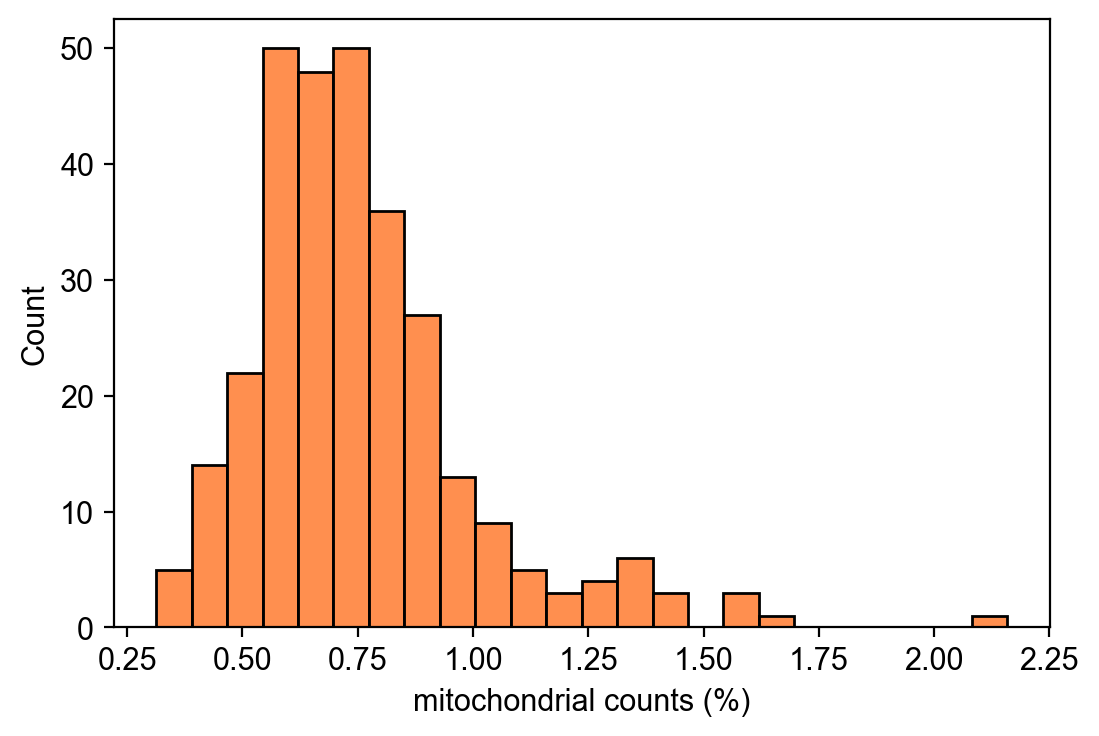

In [7]:
import seaborn as sns

ax = sns.histplot(
    adata.obs,
    x="pct_counts_mt",
    color="#ff6a14",
)
ax.set_xlabel("mitochondrial counts (%)")

Text(0.5, 0, 'ribosomal counts (%)')

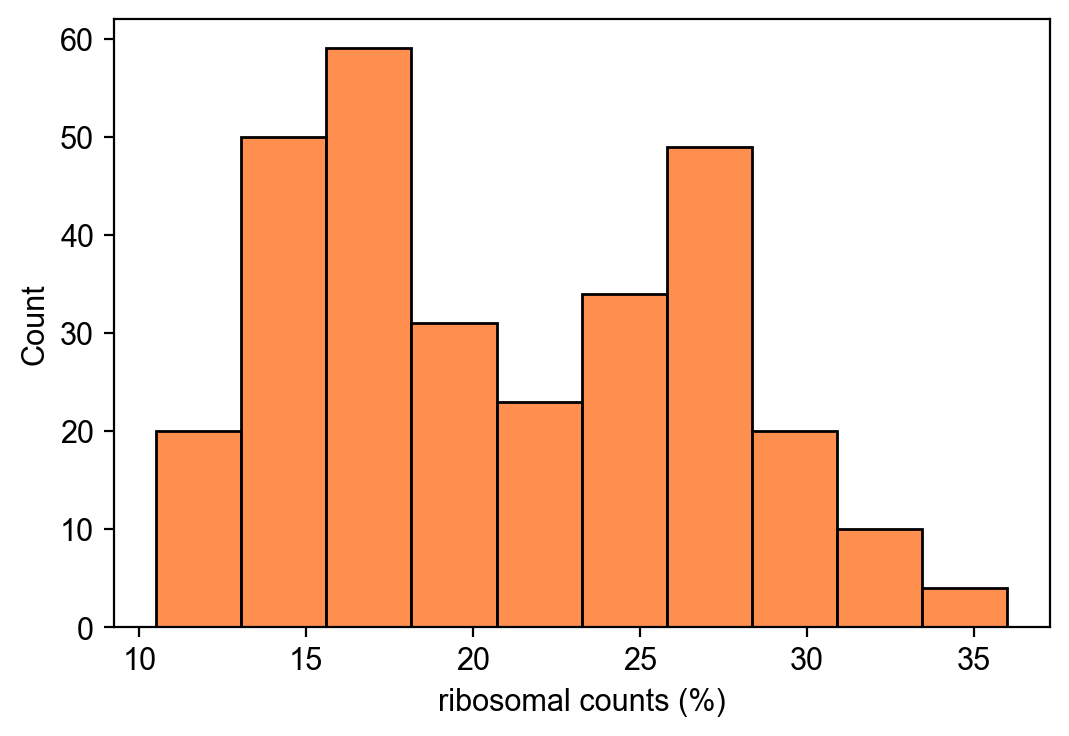

In [8]:
ax = sns.histplot(
    adata.obs,
    x="pct_counts_ribo",
    color="#ff6a14",
)
ax.set_xlabel("ribosomal counts (%)")

as well as the number of genes with at least one count in each cell and
the total counts in each cell.

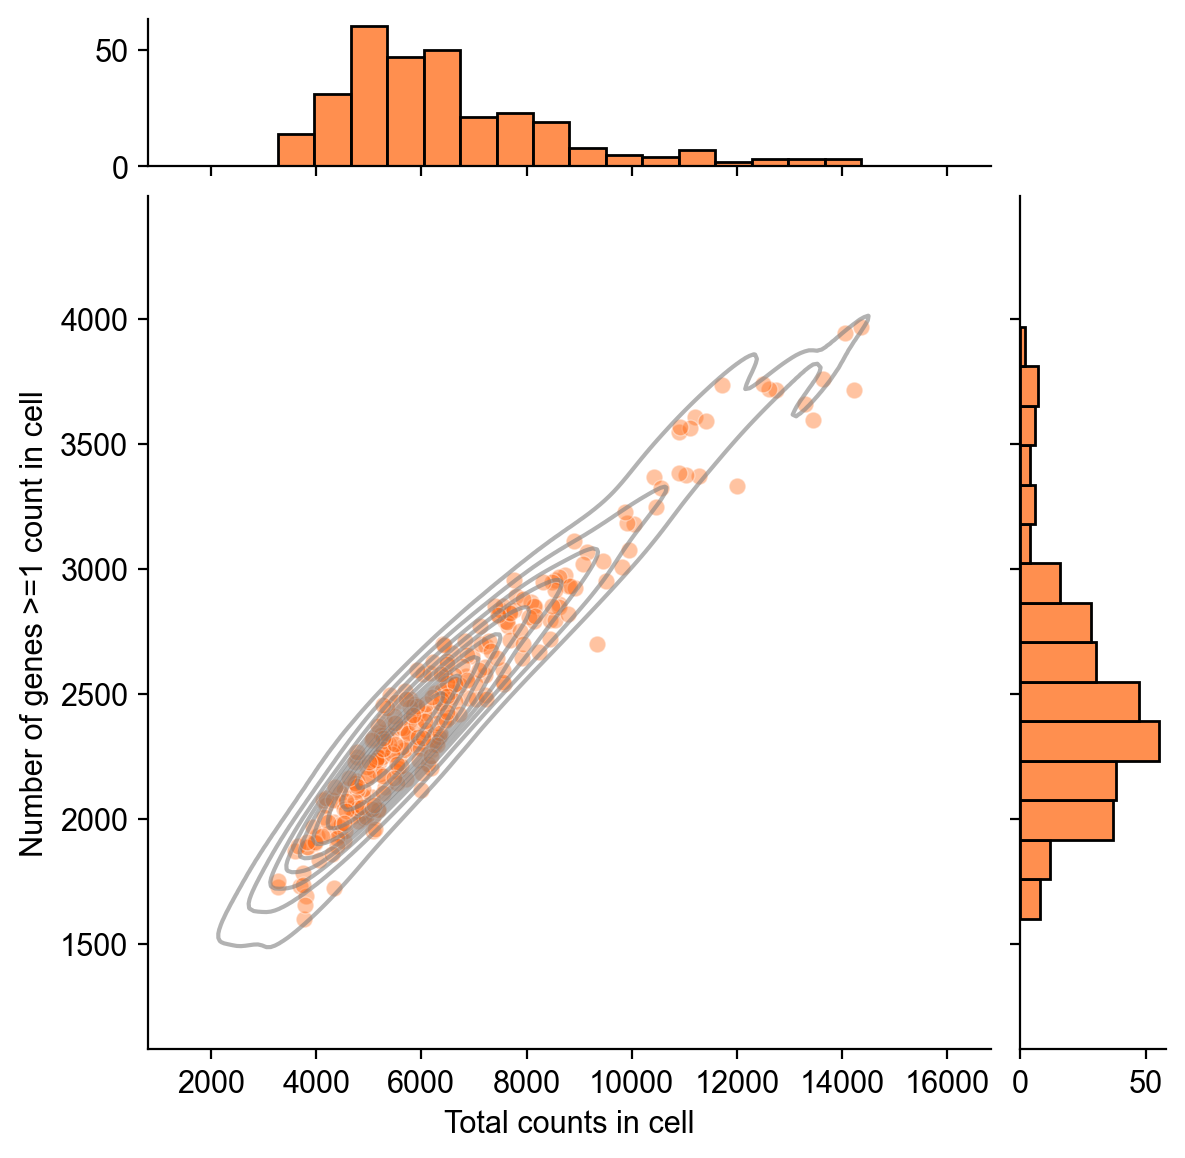

In [9]:
import seaborn as sns
import pandas as pd

numeric_obs = adata.obs.copy()
numeric_obs["n_genes_by_counts"] = pd.to_numeric(
    numeric_obs["n_genes_by_counts"],
    errors="coerce",
)
qc_counts = sns.jointplot(
    data=numeric_obs,
    x="total_counts",
    y="n_genes_by_counts",
    color="#ff6a14",
    marginal_ticks=True,
    kind="scatter",
    alpha=0.4,
)
qc_counts.plot_joint(
    sns.kdeplot,
    color="gray",
    alpha=0.6,
)
qc_counts.set_axis_labels(
    xlabel="Total counts in cell",
    ylabel="Number of genes >=1 count in cell",
)

### 2.4 Compute cytotrace statistics

For some data sets we apply cytotrace as a proxy for progression through
lineage-specific differentiation.

In [10]:
from pyrovelocity.analysis.cytotrace import cytotrace_sparse

cytotrace_sparse(adata, layer="spliced")
cytotrace_representation = anndata_string(adata)
print_string_diff(
    text1=copied_raw_counts_representation,
    text2=cytotrace_representation,
    diff_title="Cytotrace diff",
)

╭────────────── Cytotrace diff ───────────────╮ 
 │ │ 
 │ --- +++ @@ -7,8 +7,25 @@ G2M_score, │ 
 │ u_lib_size_raw, │ 
 │ s_lib_size_raw, │ 
 │ + n_genes_by_counts, │ 
 │ + total_counts, │ 
 │ + total_counts_mt, │ 
 │ + pct_counts_mt, │ 
 │ + total_counts_ribo, │ 
 │ + pct_counts_ribo, │ 
 │ + gcs, │ 
 │ + cytotrace, │ 
 │ + counts, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ + mt, │ 
 │ + ribo, │ 
 │ + n_cells_by_counts, │ 
 │ + mean_counts, │ 
 │ + pct_dropout_by_counts, │ 
 │ + total_counts, │ 
 │ + cytotrace, │ 
 │ + cytotrace_corrs, │ 
 │ uns: │ 
 │ clusters_coarse_colors, │ 
 │ clusters_colors, │ 
 │ │ 
 │ │ 
 ╰─────────────────────────────────────────────╯

### 2.5 Filter and normalize data

Next we use the preprocessing functions built-in to the scvelo package
to filter genes that have at least a given minimum number of counts,

In [11]:
import scvelo as scv

scv.pp.filter_genes(
    adata,
    min_shared_counts=30,
)
filter_genes_representation = anndata_string(adata)
print_string_diff(
    text1=cytotrace_representation,
    text2=filter_genes_representation,
    diff_title="Filter genes diff",
)

Filtered out 26285 genes that are detected 30 counts (shared).

╭──────────────── Filter genes diff ────────────────╮ 
 │ │ 
 │ --- +++ @@ -1,5 +1,5 @@ │ 
 │ -AnnData object with n_obs × n_vars = 300 × 27998 │ 
 │ +AnnData object with n_obs × n_vars = 300 × 1713 │ 
 │ obs: │ 
 │ clusters_coarse, │ 
 │ clusters, │ 
 │ @@ -16,6 +16,9 @@ gcs, │ 
 │ cytotrace, │ 
 │ counts, │ 
 │ + initial_size_unspliced, │ 
 │ + initial_size_spliced, │ 
 │ + initial_size, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ mt, │ 
 │ │ 
 │ │ 
 ╰───────────────────────────────────────────────────╯

normalize the data,

In [12]:
scv.pp.normalize_per_cell(adata)
normalize_representation = anndata_string(adata)
print_string_diff(
    text1=filter_genes_representation,
    text2=normalize_representation,
    diff_title="Normalize per cell diff",
)

Normalized count data: X, spliced, unspliced.

╭───────────────── Normalize per cell diff ─────────────────╮ 
 │ │ 
 │ --- +++ @@ -19,6 +19,7 @@ initial_size_unspliced, │ 
 │ initial_size_spliced, │ 
 │ initial_size, │ 
 │ + n_counts, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ mt, │ 
 │ │ 
 │ │ 
 ╰───────────────────────────────────────────────────────────╯

and filter the genes by their degree of dispersion.

In [13]:
scv.pp.filter_genes_dispersion(
    adata,
    n_top_genes=2000,
)
filter_dispersion_representation = anndata_string(adata)
print_string_diff(
    text1=normalize_representation,
    text2=filter_dispersion_representation,
    diff_title="Filter dispersion diff",
)

Skip filtering by dispersion since number of variables are less than `n_top_genes`.

╭─ Filter dispersion diff ─╮ 
 │ │ 
 │ │ 
 │ │ 
 ╰──────────────────────────╯

Aside from the observation-level subsampling these operations are
destructive and so you would need to reload the data to recover its
original state after attempting to apply them.

Finally we use the scanpy package to log-transform the data. Note again
we’ve retained the count data and are only doing this as it is expected
by a variety of downstream analysis tools.

In [14]:
import scanpy as sc

sc.pp.log1p(adata)
preprocessed_data_state_representation = anndata_string(adata)
print_string_diff(
    text1=filter_dispersion_representation,
    text2=preprocessed_data_state_representation,
    diff_title="Log transform diff",
)

╭───────────── Log transform diff ──────────────╮ 
 │ │ 
 │ --- +++ @@ -36,6 +36,7 @@ day_colors, │ 
 │ neighbors, │ 
 │ pca, │ 
 │ + log1p, │ 
 │ obsm: │ 
 │ X_pca, │ 
 │ X_umap, │ 
 │ │ 
 │ │ 
 ╰───────────────────────────────────────────────╯

Having executed this series of functions we’ve added or updated the
following components relative to the initial data state

In [15]:
print_string_diff(
    text1=initial_data_state_representation,
    text2=preprocessed_data_state_representation,
    diff_title="Filtration and normalization summary diff",
    diff_context_lines=5,
)

╭──── Filtration and normalization summary diff ─────╮ 
 │ │ 
 │ --- +++ @@ -1,24 +1,50 @@ │ 
 │ -AnnData object with n_obs × n_vars = 3696 × 27998 │ 
 │ +AnnData object with n_obs × n_vars = 300 × 1713 │ 
 │ obs: │ 
 │ clusters_coarse, │ 
 │ clusters, │ 
 │ S_score, │ 
 │ G2M_score, │ 
 │ + u_lib_size_raw, │ 
 │ + s_lib_size_raw, │ 
 │ + n_genes_by_counts, │ 
 │ + total_counts, │ 
 │ + total_counts_mt, │ 
 │ + pct_counts_mt, │ 
 │ + total_counts_ribo, │ 
 │ + pct_counts_ribo, │ 
 │ + gcs, │ 
 │ + cytotrace, │ 
 │ + counts, │ 
 │ + initial_size_unspliced, │ 
 │ + initial_size_spliced, │ 
 │ + initial_size, │ 
 │ + n_counts, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ + mt, │ 
 │ + ribo, │ 
 │ + n_cells_by_counts, │ 
 │ + mean_counts, │ 
 │ + pct_dropout_by_counts, │ 
 │ + total_counts, │ 
 │ + cytotrace, │ 
 │ + cytotrace_corrs, │ 
 │ uns: │ 
 │ clusters_coarse_colors, │ 
 │ clusters_colors, │ 
 │ day_colors, │ 
 │ neighbors, │ 
 │ pca, │ 
 │ + log1p, │ 
 │ obsm: │ 
 │ X_pca, │ 
 │ X_umap, │ 
 │ layers: │ 
 │ spliced, │ 
 │ unspliced, │ 
 │ + raw_unspliced, │ 
 │ + raw_spliced, │ 
 │ obsp: │ 
 │ distances, │ 
 │ connectivities, │ 
 │ │ 
 ╰────────────────────────────────────────────────────╯

### 2.6 Compute nearest neighbors graph

We do not make direct use of nearest neighbor graphs, and some data sets
come with one precomputed, but we recompute the graph for
cross-compatability with other tools that may require it.

In [16]:
sc.pp.neighbors(
    adata=adata,
    n_pcs=30,
    n_neighbors=30,
)
nearest_neighbors_representation = anndata_string(adata)
print_string_diff(
    text1=preprocessed_data_state_representation,
    text2=nearest_neighbors_representation,
    diff_title="Nearest neighbors diff",
)

╭─ Nearest neighbors diff ─╮ 
 │ │ 
 │ │ 
 │ │ 
 ╰──────────────────────────╯

The nearest neighbor graph is used in particular for
nearest-neighbor-based averaging of gene expression

In [17]:
scv.pp.moments(
    data=adata,
    n_pcs=30,
    n_neighbors=30,
)
nearest_neighbor_averaged_representation = anndata_string(adata)
print_string_diff(
    text1=nearest_neighbors_representation,
    text2=nearest_neighbor_averaged_representation,
    diff_title="Nearest neighbor averaged diff",
)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)

╭─────── Nearest neighbor averaged diff ───────╮ 
 │ │ 
 │ --- +++ @@ -45,6 +45,8 @@ unspliced, │ 
 │ raw_unspliced, │ 
 │ raw_spliced, │ 
 │ + Ms, │ 
 │ + Mu, │ 
 │ obsp: │ 
 │ distances, │ 
 │ connectivities, │ 
 │ │ 
 ╰──────────────────────────────────────────────╯

### 2.7 Estimate expression dynamics

We compute the estimates of the expression dynamics parameters using the
EM-based maximum-likelihood algorithm from the scvelo package

In [18]:
scv.tl.recover_dynamics(
    data=adata,
    n_jobs=-1,
    use_raw=False,
)
em_ml_dynamics_representation = anndata_string(adata)
print_string_diff(
    text1=nearest_neighbor_averaged_representation,
    text2=em_ml_dynamics_representation,
    diff_title="EM ML dynamics diff",
)

recovering dynamics (using 16/16 cores)
    finished (0:00:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

╭────────────── EM ML dynamics diff ───────────────╮ 
 │ │ 
 │ --- +++ @@ -30,6 +30,22 @@ total_counts, │ 
 │ cytotrace, │ 
 │ cytotrace_corrs, │ 
 │ + fit_r2, │ 
 │ + fit_alpha, │ 
 │ + fit_beta, │ 
 │ + fit_gamma, │ 
 │ + fit_t_, │ 
 │ + fit_scaling, │ 
 │ + fit_std_u, │ 
 │ + fit_std_s, │ 
 │ + fit_likelihood, │ 
 │ + fit_u0, │ 
 │ + fit_s0, │ 
 │ + fit_pval_steady, │ 
 │ + fit_steady_u, │ 
 │ + fit_steady_s, │ 
 │ + fit_variance, │ 
 │ + fit_alignment_scaling, │ 
 │ uns: │ 
 │ clusters_coarse_colors, │ 
 │ clusters_colors, │ 
 │ @@ -37,9 +53,12 @@ neighbors, │ 
 │ pca, │ 
 │ log1p, │ 
 │ + recover_dynamics, │ 
 │ obsm: │ 
 │ X_pca, │ 
 │ X_umap, │ 
 │ + varm: │ 
 │ + loss, │ 
 │ layers: │ 
 │ spliced, │ 
 │ unspliced, │ 
 │ @@ -47,6 +66,9 @@ raw_spliced, │ 
 │ Ms, │ 
 │ Mu, │ 
 │ + fit_t, │ 
 │ + fit_tau, │ 
 │ + fit_tau_, │ 
 │ obsp: │ 
 │ distances, │ 
 │ connectivities, │ 
 │ │ 
 ╰──────────────────────────────────────────────────╯

and use these to estimate the gene-specific velocities.

In [19]:
scv.tl.velocity(
    data=adata,
    mode="dynamical",
    use_raw=False,
)
em_ml_velocities_representation = anndata_string(adata)
print_string_diff(
    text1=em_ml_dynamics_representation,
    text2=em_ml_velocities_representation,
    diff_title="EM ML velocities diff",
)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)

╭───────────── EM ML velocities diff ─────────────╮ 
 │ │ 
 │ --- +++ @@ -46,6 +46,7 @@ fit_steady_s, │ 
 │ fit_variance, │ 
 │ fit_alignment_scaling, │ 
 │ + velocity_genes, │ 
 │ uns: │ 
 │ clusters_coarse_colors, │ 
 │ clusters_colors, │ 
 │ @@ -54,6 +55,7 @@ pca, │ 
 │ log1p, │ 
 │ recover_dynamics, │ 
 │ + velocity_params, │ 
 │ obsm: │ 
 │ X_pca, │ 
 │ X_umap, │ 
 │ @@ -69,6 +71,8 @@ fit_t, │ 
 │ fit_tau, │ 
 │ fit_tau_, │ 
 │ + velocity, │ 
 │ + velocity_u, │ 
 │ obsp: │ 
 │ distances, │ 
 │ connectivities, │ 
 │ │ 
 ╰─────────────────────────────────────────────────╯

### 2.8 Compute leiden clusters

We add leiden clustering to the data set for algorithms that work with
unlabeled clusters.

In [20]:
sc.tl.leiden(adata=adata)
leiden_representation = anndata_string(adata)
print_string_diff(
    text1=em_ml_velocities_representation,
    text2=leiden_representation,
    diff_title="Leiden clustering diff",
)

╭──────────────── Leiden clustering diff ─────────────────╮ 
 │ │ 
 │ --- +++ @@ -20,6 +20,7 @@ initial_size_spliced, │ 
 │ initial_size, │ 
 │ n_counts, │ 
 │ + leiden, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ mt, │ 
 │ @@ -56,6 +57,7 @@ log1p, │ 
 │ recover_dynamics, │ 
 │ velocity_params, │ 
 │ + leiden, │ 
 │ obsm: │ 
 │ X_pca, │ 
 │ X_umap, │ 
 │ │ 
 │ │ 
 ╰─────────────────────────────────────────────────────────╯

### 2.9 Subset genes

We also subset the genes to a smaller number to enable faster
illustration of model training and inference even on laptops with
significantly limited resources.

In [21]:
likelihood_sorted_genes = (
    adata.var["fit_likelihood"].sort_values(ascending=False).index
)

if PYROVELOCITY_DATA_SUBSET:
    adata = adata[:, likelihood_sorted_genes[:200]].copy()

subset_genes_representation = anndata_string(adata)
print_string_diff(
    text1=leiden_representation,
    text2=subset_genes_representation,
    diff_title="Subset genes diff",
)

╭─────────────── Subset genes diff ────────────────╮ 
 │ │ 
 │ --- +++ @@ -1,5 +1,5 @@ │ 
 │ -AnnData object with n_obs × n_vars = 300 × 1713 │ 
 │ +AnnData object with n_obs × n_vars = 300 × 200 │ 
 │ obs: │ 
 │ clusters_coarse, │ 
 │ clusters, │ 
 │ │ 
 │ │ 
 ╰──────────────────────────────────────────────────╯

### 2.10 Compute velocity graph

We compute the velocity graph based on cosine similarity of the
gene-specific velocities estimated by the scvelo package.

In [22]:
scv.tl.velocity_graph(
    data=adata,
    n_jobs=-1,
)
velocity_graph_representation = anndata_string(adata)
print_string_diff(
    text1=subset_genes_representation,
    text2=velocity_graph_representation,
    diff_title="Velocity graph diff",
)

computing velocity graph (using 16/16 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)

╭────────────── Velocity graph diff ──────────────╮ 
 │ │ 
 │ --- +++ @@ -21,6 +21,7 @@ initial_size, │ 
 │ n_counts, │ 
 │ leiden, │ 
 │ + velocity_self_transition, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ mt, │ 
 │ @@ -58,6 +59,8 @@ recover_dynamics, │ 
 │ velocity_params, │ 
 │ leiden, │ 
 │ + velocity_graph, │ 
 │ + velocity_graph_neg, │ 
 │ obsm: │ 
 │ X_pca, │ 
 │ X_umap, │ 
 │ │ 
 │ │ 
 ╰─────────────────────────────────────────────────╯

### 2.11 Compute velocity embedding

We compute the velocity embedding using the velocity graph and the
gene-specific velocities.

In [23]:
scv.tl.velocity_embedding(
    data=adata,
    basis="umap",
)
velocity_embedding_representation = anndata_string(adata)
print_string_diff(
    text1=velocity_graph_representation,
    text2=velocity_embedding_representation,
    diff_title="Velocity embedding diff",
)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)

╭────── Velocity embedding diff ──────╮ 
 │ │ 
 │ --- +++ @@ -64,6 +64,7 @@ obsm: │ 
 │ X_pca, │ 
 │ X_umap, │ 
 │ + velocity_umap, │ 
 │ varm: │ 
 │ loss, │ 
 │ layers: │ 
 │ │ 
 │ │ 
 ╰─────────────────────────────────────╯

### 2.12 Compute gene-wise latent time

We compute the gene-specific latent time estimated by the scvelo
package.

In [24]:
scv.tl.latent_time(
    data=adata,
)
latent_time_representation = anndata_string(adata)
print_string_diff(
    text1=velocity_embedding_representation,
    text2=latent_time_representation,
    diff_title="Latent time diff",
)

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)

╭────────────── Latent time diff ──────────────╮ 
 │ │ 
 │ --- +++ @@ -22,6 +22,10 @@ n_counts, │ 
 │ leiden, │ 
 │ velocity_self_transition, │ 
 │ + root_cells, │ 
 │ + end_points, │ 
 │ + velocity_pseudotime, │ 
 │ + latent_time, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ mt, │ 
 │ │ 
 │ │ 
 ╰──────────────────────────────────────────────╯

### 2.13 Summarize preprocessing

We can finally summarize the changes induced by the preprocessing steps
applied to the data set.

In [25]:
print_string_diff(
    text1=initial_data_state_representation,
    text2=latent_time_representation,
    diff_title="Preprocessing summary diff",
    diff_context_lines=5,
)

╭──────────── Preprocessing summary diff ────────────╮ 
 │ │ 
 │ --- +++ @@ -1,24 +1,88 @@ │ 
 │ -AnnData object with n_obs × n_vars = 3696 × 27998 │ 
 │ +AnnData object with n_obs × n_vars = 300 × 200 │ 
 │ obs: │ 
 │ clusters_coarse, │ 
 │ clusters, │ 
 │ S_score, │ 
 │ G2M_score, │ 
 │ + u_lib_size_raw, │ 
 │ + s_lib_size_raw, │ 
 │ + n_genes_by_counts, │ 
 │ + total_counts, │ 
 │ + total_counts_mt, │ 
 │ + pct_counts_mt, │ 
 │ + total_counts_ribo, │ 
 │ + pct_counts_ribo, │ 
 │ + gcs, │ 
 │ + cytotrace, │ 
 │ + counts, │ 
 │ + initial_size_unspliced, │ 
 │ + initial_size_spliced, │ 
 │ + initial_size, │ 
 │ + n_counts, │ 
 │ + leiden, │ 
 │ + velocity_self_transition, │ 
 │ + root_cells, │ 
 │ + end_points, │ 
 │ + velocity_pseudotime, │ 
 │ + latent_time, │ 
 │ var: │ 
 │ highly_variable_genes, │ 
 │ + mt, │ 
 │ + ribo, │ 
 │ + n_cells_by_counts, │ 
 │ + mean_counts, │ 
 │ + pct_dropout_by_counts, │ 
 │ + total_counts, │ 
 │ + cytotrace, │ 
 │ + cytotrace_corrs, │ 
 │ + fit_r2, │ 
 │ + fit_alpha, │ 
 │ + fit_beta, │ 
 │ + fit_gamma, │ 
 │ + fit_t_, │ 
 │ + fit_scaling, │ 
 │ + fit_std_u, │ 
 │ + fit_std_s, │ 
 │ + fit_likelihood, │ 
 │ + fit_u0, │ 
 │ + fit_s0, │ 
 │ + fit_pval_steady, │ 
 │ + fit_steady_u, │ 
 │ + fit_steady_s, │ 
 │ + fit_variance, │ 
 │ + fit_alignment_scaling, │ 
 │ + velocity_genes, │ 
 │ uns: │ 
 │ clusters_coarse_colors, │ 
 │ clusters_colors, │ 
 │ day_colors, │ 
 │ neighbors, │ 
 │ pca, │ 
 │ + log1p, │ 
 │ + recover_dynamics, │ 
 │ + velocity_params, │ 
 │ + leiden, │ 
 │ + velocity_graph, │ 
 │ + velocity_graph_neg, │ 
 │ obsm: │ 
 │ X_pca, │ 
 │ X_umap, │ 
 │ + velocity_umap, │ 
 │ + varm: │ 
 │ + loss, │ 
 │ layers: │ 
 │ spliced, │ 
 │ unspliced, │ 
 │ + raw_unspliced, │ 
 │ + raw_spliced, │ 
 │ + Ms, │ 
 │ + Mu, │ 
 │ + fit_t, │ 
 │ + fit_tau, │ 
 │ + fit_tau_, │ 
 │ + velocity, │ 
 │ + velocity_u, │ 
 │ obsp: │ 
 │ distances, │ 
 │ connectivities, │ 
 │ │ 
 ╰────────────────────────────────────────────────────╯

## 3 Plots

### 3.1 Data quality

We plot the two-dimensional density of genes with greater than or equal
to one count in a given cell versus the total counts in that cell for
the data set.

In [26]:
sc.pp.calculate_qc_metrics(
    adata=adata,
    qc_vars=["mt", "ribo"],
    layer="raw_spliced",
    percent_top=None,
    log1p=False,
    inplace=True,
)
qc_metrics_representation = anndata_string(adata)
print_string_diff(
    text1=latent_time_representation,
    text2=qc_metrics_representation,
    diff_title="Quality control metrics diff",
)

╭─ Quality control metrics diff ─╮ 
 │ │ 
 │ │ 
 │ │ 
 ╰────────────────────────────────╯

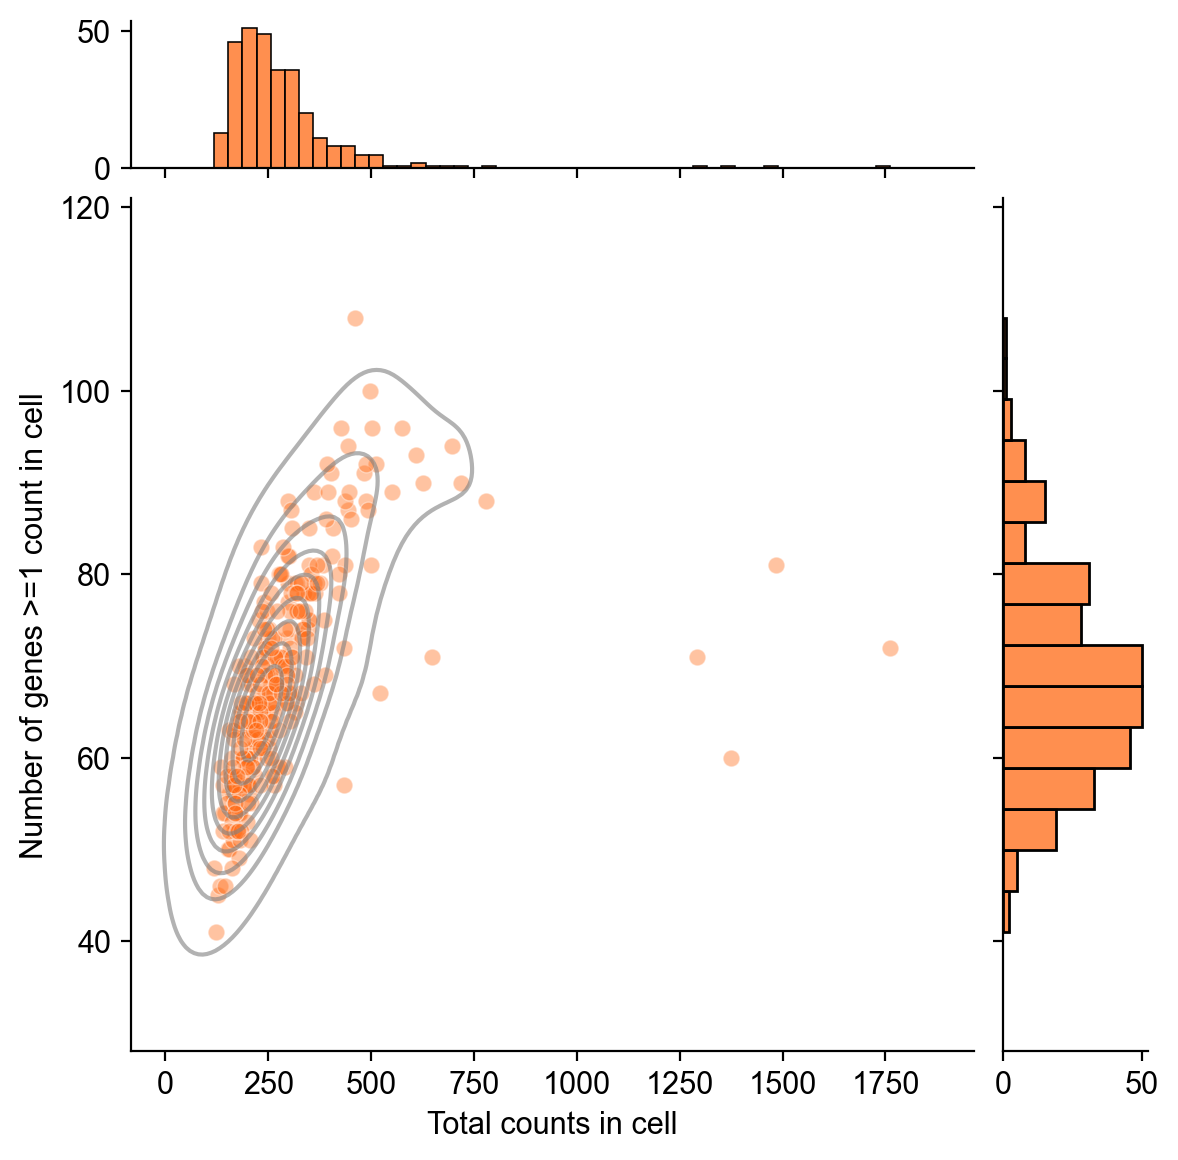

In [27]:
import seaborn as sns
import pandas as pd

numeric_obs = adata.obs.copy()
numeric_obs["n_genes_by_counts"] = pd.to_numeric(
    numeric_obs["n_genes_by_counts"],
    errors="coerce",
)
qc_counts = sns.jointplot(
    data=numeric_obs,
    x="total_counts",
    y="n_genes_by_counts",
    color="#ff6a14",
    marginal_ticks=True,
    kind="scatter",
    alpha=0.4,
)
qc_counts.plot_joint(
    sns.kdeplot,
    color="gray",
    alpha=0.6,
)
qc_counts.set_axis_labels(
    xlabel="Total counts in cell",
    ylabel="Number of genes >=1 count in cell",
)

### 3.2 Splice state

We can plot the raw data to ensure we have a general understanding of
its sparsity, which may be associated with quality. We can also plot the
raw spliced and unspliced counts.

In [28]:
from pyrovelocity.plots import plot_spliced_unspliced_histogram

chart = plot_spliced_unspliced_histogram(
    adata=adata,
    spliced_layer="raw_spliced",
    unspliced_layer="raw_unspliced",
    min_count=3,
    max_count=200,
)
chart.save("us_histogram.pdf")
chart